In [43]:
import vi
from vi.dataset import GmmDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from vi.models import SVAEC, VAE, UVAE
from vi.inference import JointSemiSupervisedVariationalInference, VariationalInference, JointSemiSupervisedVariationalInferenceUncertain
from vi.dataset import TestDataset
import torch
% matplotlib inline

In [44]:
def compute_predictions(vae, data_loader, classifier=None):
    all_y_pred = []
    all_y = []
    values = []

    for i_batch, tensors in enumerate(data_loader):
        sample_batch, labels = tensors
        all_y += [labels.view(-1)]

        if hasattr(vae, 'classify'):
            y_pred = vae.classify(sample_batch).argmax(dim=-1)
        elif classifier is not None:
            # Then we use the specified classifier
            if vae is not None:
                sample_batch, _, _ = vae.z_encoder(sample_batch)
            y_pred = classifier(sample_batch).argmax(dim=-1)
        all_y_pred += [y_pred]

    all_y_pred = np.array(torch.cat(all_y_pred))
    all_y = np.array(torch.cat(all_y))
    return all_y, all_y_pred

In [60]:
def compute_ratio(p):
    """
    Computes classification ratio according to probability
    as specified in the model
    """
    return np.log(p)-np.log(1-p)


def compute_ratios(n_0, n_1, corruption_probability_0_1, corruption_probability_1_0):
    """ 
    Computes the classification ratios according to our model and the corruption probability
    of the data
    """
    p_0 = n_0 / (n_0 + n_1 * corruption_probability_1_0)
    p_1 = n_1 / (n_1 + n_0 * corruption_probability_0_1)
    return compute_ratio(p_0), compute_ratio(p_1)
    

In [61]:
dataset = GmmDataset(5, 100, np.array([0.5, 0.5]), np.array([[0, 0, 0, 1, 1], [2, 2, 1, 0, 0]]),
                     np.array([[1, 1, 1, 1, 1], [2, 2, 2, 3, 3]]), total_size=5000)

In [62]:
acc_svaec_corrupt = []
acc_svaec_real = []
acc_uvae_corrupt = []
acc_uvae_real = []

1.3862943611198908
2.3025850929940455
training: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
0.92
training: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]
0.9136


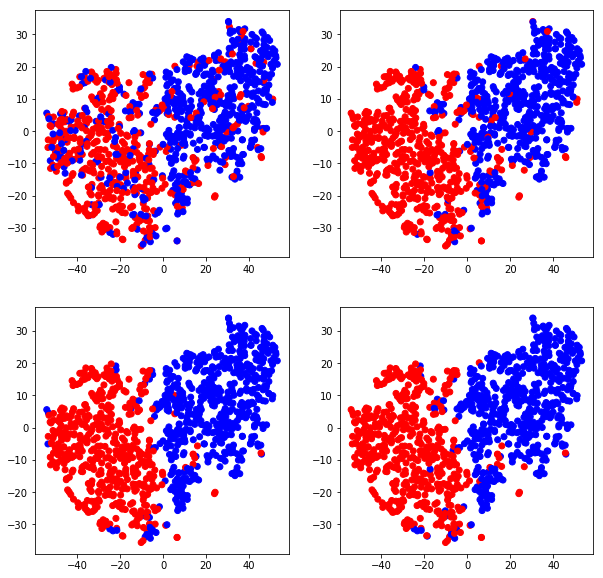

In [73]:
corruption_probability_0_1 = 0.1
corruption_probability_1_0 = 0.25
# corrupting the labels
new_labels = np.zeros_like(dataset.labels)
for i, label in enumerate(dataset.labels):
    if label == 0:
        p = np.random.binomial(1, corruption_probability_0_1)
        if p < 0.5:
            new_labels[i] = 0
        else:
            new_labels[i] = 1
    else:
        p = np.random.binomial(1, corruption_probability_1_0)
        if p < 0.5:
            new_labels[i] = 1
        else:
            new_labels[i] = 0

new_dataset = TestDataset(dataset.X, new_labels)
cl_0, cl_1 = compute_ratios(0.5, 0.5, corruption_probability_0_1, corruption_probability_1_0)
print(cl_0)
print(cl_1)

uvae = UVAE(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInferenceUncertain(uvae, new_dataset, n_labelled_samples_per_class=10,
                                                          classification_ratio=[cl_0,cl_1], verbose=False, frequency=1)
infer.train(n_epochs=200)

svaec = SVAEC(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInference(svaec, new_dataset, n_labelled_samples_per_class=10, verbose=False, frequency=1)
# Train the model, look at the accuracy on the corrupted dataset
infer.train(n_epochs=200)


# look at the accuracy on the real dataset
infer = JointSemiSupervisedVariationalInference(uvae, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

infer = JointSemiSupervisedVariationalInference(svaec, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

# Look at the labelling in the latent space
X = new_dataset.X
x_ = torch.from_numpy(X).type(torch.FloatTensor)
all_y_pred = []
y_pred = svaec.classify(x_).argmax(dim=-1)
all_y_pred = np.array(y_pred)

y_pred_custom = uvae.classify(x_).argmax(dim=-1)
all_y_pred_custom = np.array(y_pred_custom)

idx_t_sne = np.random.permutation(X.shape[0])[:1000]
X_embedded = TSNE(n_components=2).fit_transform(X[idx_t_sne, :])


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=new_dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(222)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(223)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(224)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred_custom[idx_t_sne].ravel(), cmap="bwr")
plt.show()

0.9162907318741551
2.3025850929940455
training: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]
0.9156
training: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
0.8684


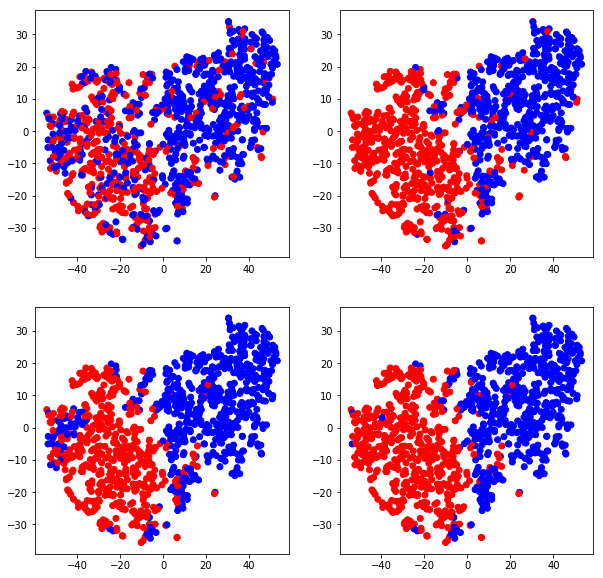

In [72]:
corruption_probability_0_1 = 0.1
corruption_probability_1_0 = 0.4
# corrupting the labels
new_labels = np.zeros_like(dataset.labels)
for i, label in enumerate(dataset.labels):
    if label == 0:
        p = np.random.binomial(1, corruption_probability_0_1)
        if p < 0.5:
            new_labels[i] = 0
        else:
            new_labels[i] = 1
    else:
        p = np.random.binomial(1, corruption_probability_1_0)
        if p < 0.5:
            new_labels[i] = 1
        else:
            new_labels[i] = 0

new_dataset = TestDataset(dataset.X, new_labels)
cl_0, cl_1 = compute_ratios(0.5, 0.5, corruption_probability_0_1, corruption_probability_1_0)
print(cl_0)
print(cl_1)

uvae = UVAE(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInferenceUncertain(uvae, new_dataset, n_labelled_samples_per_class=10,
                                                          classification_ratio=[cl_0,cl_1], verbose=False, frequency=1)
infer.train(n_epochs=200)
acc_uvae_corrupt.append(infer.accuracy('unlabelled'))

svaec = SVAEC(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInference(svaec, new_dataset, n_labelled_samples_per_class=10, verbose=False, frequency=1)
# Train the model, look at the accuracy on the corrupted dataset
infer.train(n_epochs=200)


# look at the accuracy on the real dataset
infer = JointSemiSupervisedVariationalInference(uvae, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

infer = JointSemiSupervisedVariationalInference(svaec, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

# Look at the labelling in the latent space
X = new_dataset.X
x_ = torch.from_numpy(X).type(torch.FloatTensor)
all_y_pred = []
y_pred = svaec.classify(x_).argmax(dim=-1)
all_y_pred = np.array(y_pred)

y_pred_custom = uvae.classify(x_).argmax(dim=-1)
all_y_pred_custom = np.array(y_pred_custom)

idx_t_sne = np.random.permutation(X.shape[0])[:1000]
X_embedded = TSNE(n_components=2).fit_transform(X[idx_t_sne, :])


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=new_dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(222)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(223)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(224)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred_custom[idx_t_sne].ravel(), cmap="bwr")
plt.show()

1.2039728043259357
2.3025850929940455
training: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]
0.918
training: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
0.9142


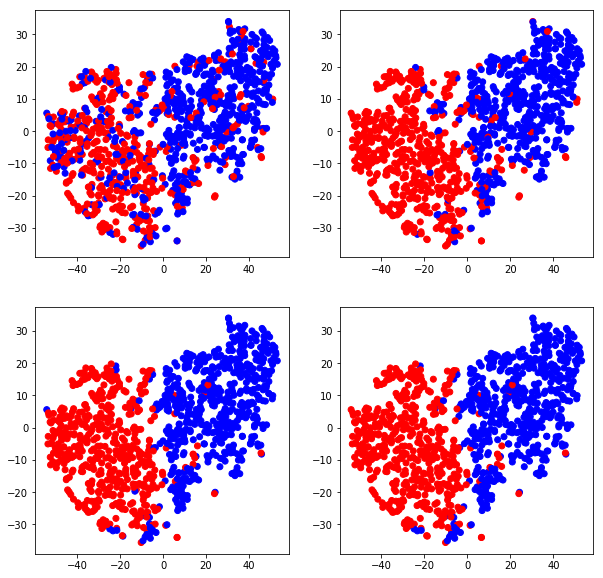

In [74]:
corruption_probability_0_1 = 0.1
corruption_probability_1_0 = 0.3
# corrupting the labels
new_labels = np.zeros_like(dataset.labels)
for i, label in enumerate(dataset.labels):
    if label == 0:
        p = np.random.binomial(1, corruption_probability_0_1)
        if p < 0.5:
            new_labels[i] = 0
        else:
            new_labels[i] = 1
    else:
        p = np.random.binomial(1, corruption_probability_1_0)
        if p < 0.5:
            new_labels[i] = 1
        else:
            new_labels[i] = 0

new_dataset = TestDataset(dataset.X, new_labels)
cl_0, cl_1 = compute_ratios(0.5, 0.5, corruption_probability_0_1, corruption_probability_1_0)
print(cl_0)
print(cl_1)

uvae = UVAE(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInferenceUncertain(uvae, new_dataset, n_labelled_samples_per_class=10,
                                                          classification_ratio=[cl_0,cl_1], verbose=False, frequency=1)
infer.train(n_epochs=200)
acc_uvae_corrupt.append(infer.accuracy('unlabelled'))

svaec = SVAEC(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInference(svaec, new_dataset, n_labelled_samples_per_class=10, verbose=False, frequency=1)
# Train the model, look at the accuracy on the corrupted dataset
infer.train(n_epochs=200)
acc_svaec_corrupt.append(infer.accuracy('unlabelled'))


# look at the accuracy on the real dataset
infer = JointSemiSupervisedVariationalInference(uvae, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

infer = JointSemiSupervisedVariationalInference(svaec, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

# Look at the labelling in the latent space
X = new_dataset.X
x_ = torch.from_numpy(X).type(torch.FloatTensor)
all_y_pred = []
y_pred = svaec.classify(x_).argmax(dim=-1)
all_y_pred = np.array(y_pred)

y_pred_custom = uvae.classify(x_).argmax(dim=-1)
all_y_pred_custom = np.array(y_pred_custom)

idx_t_sne = np.random.permutation(X.shape[0])[:1000]
X_embedded = TSNE(n_components=2).fit_transform(X[idx_t_sne, :])

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=new_dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(222)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(223)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(224)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred_custom[idx_t_sne].ravel(), cmap="bwr")
plt.show()

0.9162907318741551
1.6094379124341005
training: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
0.6846
training: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
0.6588


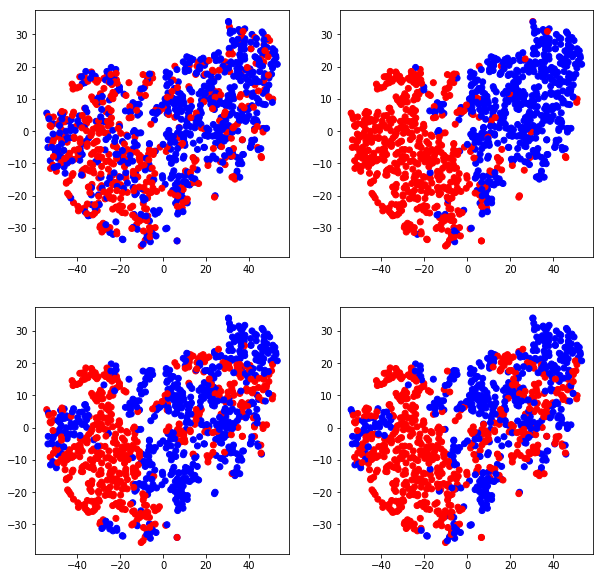

In [70]:
corruption_probability_0_1 = 0.2
corruption_probability_1_0 = 0.4
# corrupting the labels
new_labels = np.zeros_like(dataset.labels)
for i, label in enumerate(dataset.labels):
    if label == 0:
        p = np.random.binomial(1, corruption_probability_0_1)
        if p < 0.5:
            new_labels[i] = 0
        else:
            new_labels[i] = 1
    else:
        p = np.random.binomial(1, corruption_probability_1_0)
        if p < 0.5:
            new_labels[i] = 1
        else:
            new_labels[i] = 0

new_dataset = TestDataset(dataset.X, new_labels)
cl_0, cl_1 = compute_ratios(0.5, 0.5, corruption_probability_0_1, corruption_probability_1_0)
print(cl_0)
print(cl_1)

uvae = UVAE(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInferenceUncertain(uvae, new_dataset, n_labelled_samples_per_class=10,
                                                          classification_ratio=[cl_0,cl_1], verbose=False, frequency=1)
infer.train(n_epochs=200)

svaec = SVAEC(100, dataset.n_labels, n_latent=2, dropout_rate=0.2, n_hidden=52)
infer = JointSemiSupervisedVariationalInference(svaec, new_dataset, n_labelled_samples_per_class=10, verbose=False, frequency=1)
# Train the model, look at the accuracy on the corrupted dataset
infer.train(n_epochs=200)


# look at the accuracy on the real dataset
infer = JointSemiSupervisedVariationalInference(uvae, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

infer = JointSemiSupervisedVariationalInference(svaec, dataset, n_labelled_samples_per_class=50)
infer.train(n_epochs=1, lr=0)
print(infer.accuracy('all'))

# Look at the labelling in the latent space
X = new_dataset.X
x_ = torch.from_numpy(X).type(torch.FloatTensor)
all_y_pred = []
y_pred = svaec.classify(x_).argmax(dim=-1)
all_y_pred = np.array(y_pred)

y_pred_custom = uvae.classify(x_).argmax(dim=-1)
all_y_pred_custom = np.array(y_pred_custom)

idx_t_sne = np.random.permutation(X.shape[0])[:1000]
X_embedded = TSNE(n_components=2).fit_transform(X[idx_t_sne, :])


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=new_dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(222)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=dataset.labels[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(223)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred[idx_t_sne].ravel(), cmap="bwr")
plt.subplot(224)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=all_y_pred_custom[idx_t_sne].ravel(), cmap="bwr")
plt.show()